## Skrypt do trenowania detektora maski na twarzy

### Pobranie datasetu prosto z Kaggle
#### Należy zalogować się do Kaggla i postępować zgodnie z instrukcją: https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/

In [4]:
import opendatasets as od
od.download("https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset")

100%|██████████| 330M/330M [00:25<00:00, 13.5MB/s] 


In [11]:
DIR_TRAIN = 'face-mask-12k-images-dataset/Face Mask Dataset/Train'
DIR_TEST = 'face-mask-12k-images-dataset/Face Mask Dataset/Test'
DIR_VAL = 'face-mask-12k-images-dataset/Face Mask Dataset/Validation'

import tensorflow as tf
import os
import cv2
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

img_height = 160
img_width = 160
img_depth = 3
image_size = (img_height, img_width)

# Load dataset
train_ds = image_dataset_from_directory(
    directory=DIR_TRAIN,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    color_mode='rgb',
    image_size=image_size,
    shuffle=True)

test_ds = image_dataset_from_directory(
    directory=DIR_TEST,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    color_mode='rgb',
    image_size=image_size,
    shuffle=True)

val_ds = image_dataset_from_directory(
    directory=DIR_VAL,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    color_mode='rgb',
    image_size=image_size,
    shuffle=True)



Found 10000 files belonging to 2 classes.
Found 992 files belonging to 2 classes.
Found 800 files belonging to 2 classes.


Wizualizacja danych

/home/dac/anaconda3/envs/studia/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


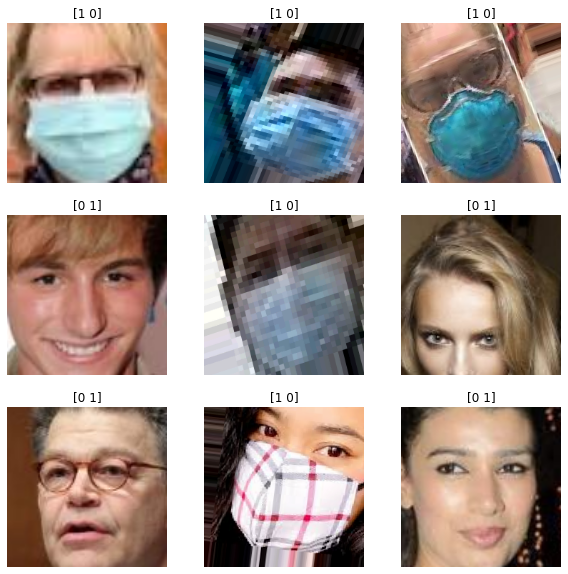

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy().astype("uint8"))
        plt.axis("off")

## Use MobileNetV2 as a base model

In [13]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
width = 160
height = 160
depth = 3

input_shape = (width, height, depth)

# not used yet
inp = Input(shape = input_shape)
normalize=Rescaling(1./255)(inp)

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape,
    input_tensor = normalize
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=preds)
for i,layer in enumerate(model.layers):
  print(i,layer.name, layer.trainable)


ModuleNotFoundError: No module named 'tensorflow.keras.experimental.prerpocesing'

In [72]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
# Tensorboard i inne callbacki
from datetime import datetime
logdir="logs\\fit\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
best_model_path = 'models/model_{}.h5'.format(datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
ms_callback = tf.keras.callbacks.ModelCheckpoint(
    best_model_path,
    monitor="val_loss",
    save_best_only=True,
)



# TRAIN MODEL

In [77]:
epochs = 20
history = model.fit(train_ds, epochs = epochs, validation_data = val_ds, verbose=1, callbacks=[tensorboard_callback, es_callback, ms_callback])

C:\Users\Czarek\anaconda3\envs\pytong3_8\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/2
313/313 [==============================] - 192s 612ms/step - loss: 0.0332 - accuracy: 0.9881 - val_loss: 0.1108 - val_accuracy: 0.9762
Epoch 2/2
313/313 [==============================] - 198s 631ms/step - loss: 0.0257 - accuracy: 0.9915 - val_loss: 0.0909 - val_accuracy: 0.9787


In [78]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plot_path='train_history/plot_{}.png'.format(datetime.now().strftime("%Y%m%d-%H%M%S"))
csv_path='train_history/istory_{}.csv'.format(datetime.now().strftime("%Y%m%d-%H%M%S"))

def plot_history(history):

    figure(figsize=(20, 16), dpi=80)
    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    fig.savefig(plot_path)

def save_history(history):
    with open(csv_path, 'w') as f:
        for key in history.history.keys():
            f.write("%s,%s\n"%(key, history.history[key]))

<Figure size 1600x1280 with 0 Axes>

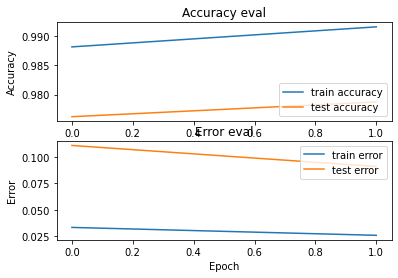

In [79]:
plot_history(history)
save_history(history)

## To use tensorboard type, the tensorboard need to be installed in python env.
## To run it type `tensorboard --logdir logs` in the shell or anaconda prompt. This command returns smth like 
## `http://localhost:6006/`. Whole history training can be monitored and analyzed in the web browswer.